In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
database = ("Resources/hawaii.sqlite")
engine = create_engine(f"sqlite:///{database}")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# alternate method to view classes
inspect(engine).get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# print column names and types for both classes
for column in inspect(engine).get_columns('measurement'):
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
for column in inspect(engine).get_columns('station'):
    print(column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date).first()[0]
print(f"Most recent date in the data is {recent_date}")

Most recent date in the data is 2010-01-01


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

In [14]:
# Finding the last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")
last_date = last_date.date()
print(last_date)

2017-08-23


In [15]:
# Going back one year
start_date = last_date - dt.timedelta(days=365)
print(start_date)

2016-08-23


In [16]:
# Perform a query to retrieve the data and precipitation scores
selection = [Measurement.date, Measurement.prcp]
data = session.query(*selection).filter(Measurement.date <= last_date).filter(Measurement.date >= start_date).all()

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data, columns=['date','prcp']).set_index('date')
df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.agg(["count","mean","median","min","max","std","sem"])

,prcp
count,2021.000000
mean,0.177279
median,0.020000
min,0.000000
max,6.700000
std,0.461190
sem,0.010259


In [19]:
#sort index 
df = df.sort_index()

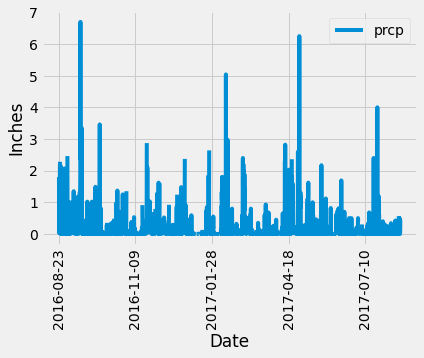

In [20]:
#plot a line chart for the data
chart = df.plot(kind="line", legend=True)
chart.set_xlabel("Date")
chart.set_ylabel("Inches")
plt.xticks(rotation="vertical")
plt.show()

# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [22]:
#verify number of stations
session.query(Station.id).distinct().count()

9

In [23]:
# Design a query to find the most active stations 
# (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

session.query(Station.name, Measurement.station, func.count(Measurement.prcp))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.prcp).desc())\
.filter(Measurement.station == Station.station).all()

[('WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('KANEOHE 838.1, HI US', 'USC00513117', 2696),
 ('WAIKIKI 717.2, HI US', 'USC00519397', 2685),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2572),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2484),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 1937),
 ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1932),
 ('PEARL CITY, HI US', 'USC00517948', 683),
 ('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 342)]

In [24]:
# View data in a dataframe

station_count = []
station_count =  session.query(Station.name, Measurement.station, func.count(Measurement.prcp))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.prcp).desc())\
.filter(Measurement.station == Station.station).all()
station_count_df = pd.DataFrame(station_count, columns=["station name", "station id", "station count"])
station_count_df

,station name,station id,station count
0,"WAIHEE 837.5, HI US",USC00519281,2772
1,"KANEOHE 838.1, HI US",USC00513117,2696
2,"WAIKIKI 717.2, HI US",USC00519397,2685
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2572
4,"MANOA LYON ARBO 785.2, HI US",USC00516128,2484
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,1937
6,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1932
7,"PEARL CITY, HI US",USC00517948,683
8,"UPPER WAHIAWA 874.3, HI US",USC00518838,342


In [25]:
# Filter station with the highest number of observations

top_station_id = session.query(Station.name, Measurement.station, func.count(Measurement.prcp))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.prcp).desc())\
.filter(Measurement.station == Station.station).first()[1]

print(f"Station ID with highest number of observations = {top_station_id}")

Station ID with highest number of observations = USC00519281


In [26]:
# Using the most active station id from the previous query, 
# calculate the lowest, highest, and average temperature.
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == top_station_id).all()[0][0]
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == top_station_id).all()[0][0]
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == top_station_id).all()[0][0]
print(f"Lowest Temperature for {top_station_id} = {lowest_temp}")
print(f"Highest Temperature for {top_station_id} = {highest_temp}")
print(f"Avergage Temperature for {top_station_id} = {avg_temp}")

Lowest Temperature for USC00519281 = 54.0
Highest Temperature for USC00519281 = 85.0
Avergage Temperature for USC00519281 = 71.66378066378067


In [27]:
# Using the most active station id
# FInding dates for last 12 months

final_date = session.query(Measurement.date).order_by(Measurement.date.desc()).filter(Measurement.station == top_station_id).first()[0]
final_date = dt.datetime.strptime(final_date, "%Y-%m-%d")
final_date = final_date.date()
first_date = final_date - dt.timedelta(days=365)

print(f"Start Date = {first_date}")
print(f"End Date = {final_date}")

Start Date = 2016-08-18
End Date = 2017-08-18


In [28]:
# Quering data for last 12 months - limit to 5
session.query(Measurement.tobs).filter(Measurement.date <= final_date).filter(Measurement.date >= first_date).limit(5).all()

[(80.0), (77.0), (80.0), (76.0), (77.0)]

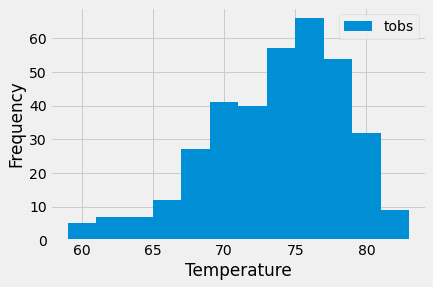

In [29]:
# observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).filter(Measurement.date <= final_date).filter(Measurement.date >= first_date).filter(Measurement.station == top_station_id).all()
temp_data = np.ravel(temp_data)
temp_data = pd.DataFrame(temp_data, columns=["tobs"])
chart = temp_data.plot(kind="hist", bins=12, legend=True)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [30]:
# Close Session
session.close()